# Mask R-CNN for Keypoint Detection

Example showing how to do keypoint detection with Mask R-CNN

In [1]:
USE_GPU = True
TRAIN   = True

%matplotlib inline
import importlib
import os

if not USE_GPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import imgaug

# Root directory of the project
ROOT_DIR = os.path.abspath(".")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load COCO Datasets for Keypoint Detection

In [2]:
from coco import coco_keypoints
importlib.reload(coco_keypoints)

# COCO dataset dir
COCO_DATA_DIR = "A:/Programming/DeepLearningDatasets/coco" if os.path.isdir("A:/Programming/DeepLearningDatasets/coco") else os.path.join(ROOT_DIR, "data/coco")

# Prepare dataset
#keypoints_to_include = ['nose', 'left_shoulder', 'right_shoulder',
#                        'left_elbow', 'right_elbow', 'left_wrist',
#                        'right_wrist', 'left_hip', 'right_hip',
#                        'left_knee', 'right_knee', 'left_ankle',
#                        'right_ankle']
keypoints_to_include = ["nose", "right_wrist"]

dataset_train = coco_keypoints.CocoDataset()
dataset_train.load_coco(COCO_DATA_DIR, subset="train", year="2017", auto_download=True, keypoints_to_include=keypoints_to_include)
dataset_train.prepare()

dataset_val = coco_keypoints.CocoDataset()
dataset_val.load_coco(COCO_DATA_DIR, subset="val", year="2017", auto_download=True, keypoints_to_include=keypoints_to_include)
dataset_val.prepare()

Will use images in /datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017
Will use annotations in /datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/annotations/person_keypoints_train2017.json
loading annotations into memory...
Done (t=8.97s)
creating index...
index created!
Will use images in /datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017
Will use annotations in /datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/annotations/person_keypoints_val2017.json
loading annotations into memory...
Done (t=0.31s)
creating index...
index created!


### Setup Training

In [3]:
class TrainConfig(Config):
    NAME = "coco_keypoints"
    
    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1 # IMAGES_PER_GPU = 2
    GPU_COUNT = 1
    
    # We use resnet50
    BACKBONE = "resnet50"
    
    # Set number of classes
    NUM_CLASSES = dataset_train.num_classes
    NUM_KEYPOINTS = dataset_train.num_kp_classes
    
    # DEBUG:
    STEPS_PER_EPOCH = 1000
    
    TRAIN_ROIS_PER_IMAGE = 100
    #MAX_GT_INSTANCES = 1
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

config = TrainConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
NAM

## Train

In [4]:
if TRAIN:
    importlib.reload(modellib)

    # Create model
    print("Creating model...")
    model = modellib.MaskRCNN(mode="training", model_dir=MODEL_DIR, config=config)

    # Load weights trained on MS-COCO
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       #exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_mask"])

Creating model...
input_gt_boxes.shape (?, ?, 4)
input_gt_kp_ids.shape (?, ?, 2)
input_gt_masks.shape (?, ?, 2, 256, 256)
gt_masks.shape (?, 2, 256, 256)
masks.shape (?, ?, ?)
kps_1d_indices.shape (?,)
kps_x.shape (?, ?, ?)
kps_x.shape (?, ?, ?)
resized_kps_x.shape (?, ?, ?)
kps_indices.shape (?, ?, ?)
masks.shape (?, ?, ?, 784)
masks.shape (?, 2, 28, 28)
target_mask.shape (1, ?, ?, ?, ?)
mrcnn_mask.shape (?, 100, 2, 28, 28)
mrcnn_mask_loss_graph shapes:
target_masks.shape (?, ?, ?)
target_kp_ids.shape (?,)
pred_masks.shape (?, ?, ?)
y_true.shape (?, ?)
y_pred.shape (?, ?)
mrcnn_mask_loss_graph shapes:
target_masks.shape (?, ?, ?)
target_kp_ids.shape (?,)
pred_masks.shape (?, ?, ?)
y_true.shape (?, ?)
y_pred.shape (?, ?)


In [5]:
if TRAIN:
    importlib.reload(modellib)

    # Training - Stage 1
    print("Training network heads...")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=4,
                layers="heads",
                augmentation=None)

Training network heads...

Starting at epoch 0. LR=0.001

Checkpoint Path: /datasets/home/78/378/cs252cas/Pose_RCNN/logs/coco_keypoints20180531T2342/mask_rcnn_coco_keypoints_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_mask_conv4       (TimeDis

/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:2023: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/4
 999/1000 [============================>.] - ETA: 0s - loss: 3.8374 - rpn_class_loss: 0.0508 - rpn_bbox_loss: 0.8263 - mrcnn_bbox_loss: 0.4668 - mrcnn_mask_loss: 2.4935

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:2251: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


1000/1000 [==============================] - 253s 253ms/step - loss: 3.8359 - rpn_class_loss: 0.0508 - rpn_bbox_loss: 0.8258 - mrcnn_bbox_loss: 0.4670 - mrcnn_mask_loss: 2.4923 - val_loss: 2.7066 - val_rpn_class_loss: 0.0317 - val_rpn_bbox_loss: 0.6459 - val_mrcnn_bbox_loss: 0.4333 - val_mrcnn_mask_loss: 1.5956
Epoch 2/4
 176/1000 [====>.........................] - ETA: 2:51 - loss: 3.0454 - rpn_class_loss: 0.0456 - rpn_bbox_loss: 0.7098 - mrcnn_bbox_loss: 0.4020 - mrcnn_mask_loss: 1.8880 ETA: 2:58 - loss: 3.0977 - rpn_class_loss: 0.0475 -

ERROR:root:Error processing image {'id': 356878, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000356878.jpg', 'width': 640, 'height': 427, 'annotations': [{'segmentation': [[4.79, 352.43, 25.85, 263.4, 44.04, 217.44, 63.19, 198.29, 89.04, 179.15, 103.4, 153.3, 102.44, 119.79, 127.33, 64.26, 155.1, 47.02, 178.08, 42.24, 190.52, 44.15, 206.8, 53.73, 223.07, 66.17, 237.43, 92.98, 238.39, 133.19, 232.65, 211.7, 232.65, 235.63, 238.39, 244.25, 238.39, 262.44, 253.71, 245.21, 267.11, 219.36, 273.82, 202.12, 284.35, 190.63, 295.84, 185.85, 324.56, 182.02, 330.3, 185.85, 339.88, 199.25, 335.09, 223.19, 333.17, 237.55, 318.81, 261.48, 226.9, 366.8, 247.97, 386.9, 258.5, 400.3, 259.46, 407.01, 262.33, 411.79, 224.03, 421.37, 4.79, 420.41]], 'num_keypoints': 10, 'area': 76882.04935, 'iscrowd': 0, 'keypoints': [191, 125, 2, 208, 111, 2, 170, 107, 2, 0, 0, 0, 118, 143, 2, 210, 227, 2, 90, 237, 2, 216, 341, 2, 127, 414, 2, 216, 363, 2, 240, 297, 2, 0, 0,

 999/1000 [============================>.] - ETA: 0s - loss: 3.0252 - rpn_class_loss: 0.0460 - rpn_bbox_loss: 0.6957 - mrcnn_bbox_loss: 0.3965 - mrcnn_mask_loss: 1.8870

ERROR:root:Error processing image {'id': 382125, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000382125.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[0, 472.97, 347.03, 475.14, 338.38, 429.73, 352.43, 370.27, 323.24, 296.76, 311.35, 255.68, 295.14, 241.62, 309.19, 152.97, 254.05, 115.14, 204.32, 123.78, 184.86, 168.11, 184.86, 196.22, 177.3, 222.16, 192.43, 237.3, 177.3, 252.43, 71.35, 290.27, 38.92, 325.95, 3.24, 395.14]], 'num_keypoints': 9, 'area': 80944.34275, 'iscrowd': 0, 'keypoints': [272, 242, 2, 285, 213, 2, 241, 212, 2, 0, 0, 0, 193, 206, 2, 296, 288, 2, 95, 321, 2, 311, 417, 2, 9, 449, 2, 0, 0, 0, 136, 431, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 382125, 'bbox': [0, 115.14, 352.43, 360], 'category_id': 1, 'id': 496515}, {'segmentation': [[36.93, 296.95, 57.75, 299.93, 61.46, 291.75, 67.41, 286.54, 69.64, 269.44, 73.36, 253.08, 77.82, 239.7, 84.51, 232.26, 95.67, 230.78, 123.92, 

IndexError: index 256 is out of bounds for axis 1 with size 256


1000/1000 [==============================] - 232s 232ms/step - loss: 3.0246 - rpn_class_loss: 0.0461 - rpn_bbox_loss: 0.6951 - mrcnn_bbox_loss: 0.3966 - mrcnn_mask_loss: 1.8867 - val_loss: 2.7114 - val_rpn_class_loss: 0.0477 - val_rpn_bbox_loss: 0.6303 - val_mrcnn_bbox_loss: 0.3839 - val_mrcnn_mask_loss: 1.6495
Epoch 3/4
1000/1000 [==============================] - 232s 232ms/step - loss: 2.8733 - rpn_class_loss: 0.0428 - rpn_bbox_loss: 0.7332 - mrcnn_bbox_loss: 0.3633 - mrcnn_mask_loss: 1.7339 - val_loss: 2.3772 - val_rpn_class_loss: 0.0371 - val_rpn_bbox_loss: 0.4605 - val_mrcnn_bbox_loss: 0.3504 - val_mrcnn_mask_loss: 1.5291
Epoch 4/4
 671/1000 [===================>..........] - ETA: 1:08 - loss: 2.9688 - rpn_class_loss: 0.0415 - rpn_bbox_loss: 0.7672 - mrcnn_bbox_loss: 0.3749 - mrcnn_mask_loss: 1.7852

ERROR:root:Error processing image {'id': 459659, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000459659.jpg', 'width': 640, 'height': 427, 'annotations': [{'segmentation': [[349.49, 196.25, 365.32, 191.25, 372.41, 187.91, 372.41, 184.16, 369.07, 185.83, 362.41, 185.83, 364.91, 171.24, 365.32, 154.57, 366.57, 146.24, 376.16, 135.82, 391.16, 131.65, 402.83, 137.07, 411.58, 153.32, 413.25, 160.83, 411.58, 168.74, 409.08, 176.24, 410.75, 183.75, 412.41, 188.75, 409.91, 190.83, 426.17, 195.41, 433.25, 202.92, 435.34, 212.92, 435.75, 221.25, 435.34, 223.75, 421.17, 219.58, 400.75, 224.59, 386.16, 236.67, 385.74, 243.75, 386.58, 247.09, 375.33, 239.59, 365.74, 235.84, 370.33, 227.5, 370.74, 222.92, 359.91, 221.67, 352.41, 220.83, 346.57, 220.83, 339.9, 221.67, 336.15, 217.92, 338.24, 212.5, 344.07, 202.92]], 'num_keypoints': 9, 'area': 5583.62165, 'iscrowd': 0, 'keypoints': [377, 165, 2, 388, 159, 2, 372, 159, 2, 0, 0, 0, 0, 0, 0, 423, 201, 2, 353

IndexError: index 256 is out of bounds for axis 1 with size 256


 822/1000 [=======================>......] - ETA: 36s - loss: 2.9342 - rpn_class_loss: 0.0418 - rpn_bbox_loss: 0.7514 - mrcnn_bbox_loss: 0.3693 - mrcnn_mask_loss: 1.7717

ERROR:root:Error processing image {'id': 563734, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000563734.jpg', 'width': 640, 'height': 427, 'annotations': [{'segmentation': [[174.96, 136.6, 169.71, 141.86, 168.96, 147.86, 170.46, 153.12, 171.21, 159.88, 171.21, 163.64, 172.71, 166.64, 178.72, 166.64, 181.72, 171.15, 180.97, 181.66, 176.47, 189.17, 173.46, 203.44, 169.71, 219.96, 169.71, 231.98, 172.71, 239.49, 174.96, 242.49, 177.22, 265.77, 178.72, 295.82, 182.48, 316.09, 173.46, 350.64, 169.71, 355.9, 162.2, 358.15, 159.94, 358.9, 163.7, 361.15, 171.21, 363.41, 195.24, 368.67, 195.24, 295.82, 195.24, 271.03, 200.5, 258.26, 205.01, 256.01, 212.52, 366.41, 220.03, 358.9, 221.53, 333.37, 212.52, 293.56, 212.52, 259.77, 223.03, 250, 221.53, 237.24, 216.27, 193.68, 203.5, 166.64, 201.25, 155.37, 199.75, 145.61, 193.74, 135.85, 184.73, 129.09, 174.21, 135.85]], 'num_keypoints': 13, 'area': 7618.46835, 'iscrowd': 0, 'keypoints': [172, 153, 2, 176

IndexError: index 256 is out of bounds for axis 1 with size 256


1000/1000 [==============================] - 232s 232ms/step - loss: 2.8983 - rpn_class_loss: 0.0421 - rpn_bbox_loss: 0.7390 - mrcnn_bbox_loss: 0.3659 - mrcnn_mask_loss: 1.7513 - val_loss: 2.6117 - val_rpn_class_loss: 0.0510 - val_rpn_bbox_loss: 0.7846 - val_mrcnn_bbox_loss: 0.3817 - val_mrcnn_mask_loss: 1.3944


In [6]:
if TRAIN:
    importlib.reload(modellib)

    # Training - Stage 2
    # Finetune layers from ResNet stage 4 and up
    print("Fine tune Resnet stage 4 and up...")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=12,
                layers="4+",
                augmentation=None)

Fine tune Resnet stage 4 and up...

Starting at epoch 4. LR=0.001

Checkpoint Path: /datasets/home/78/378/cs252cas/Pose_RCNN/logs/coco_keypoints20180531T2342/mask_rcnn_coco_keypoints_{epoch:04d}.h5
Selecting layers to train
res4a_branch2a         (Conv2D)
bn4a_branch2a          (BatchNorm)
res4a_branch2b         (Conv2D)
bn4a_branch2b          (BatchNorm)
res4a_branch2c         (Conv2D)
res4a_branch1          (Conv2D)
bn4a_branch2c          (BatchNorm)
bn4a_branch1           (BatchNorm)
res4b_branch2a         (Conv2D)
bn4b_branch2a          (BatchNorm)
res4b_branch2b         (Conv2D)
bn4b_branch2b          (BatchNorm)
res4b_branch2c         (Conv2D)
bn4b_branch2c          (BatchNorm)
res4c_branch2a         (Conv2D)
bn4c_branch2a          (BatchNorm)
res4c_branch2b         (Conv2D)
bn4c_branch2b          (BatchNorm)
res4c_branch2c         (Conv2D)
bn4c_branch2c          (BatchNorm)
res4d_branch2a         (Conv2D)
bn4d_branch2a          (BatchNorm)
res4d_branch2b         (Conv2D)
bn4d_br

/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:2023: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 5/12
 410/1000 [===========>..................] - ETA: 2:28 - loss: 2.7310 - rpn_class_loss: 0.0425 - rpn_bbox_loss: 0.7953 - mrcnn_bbox_loss: 0.3501 - mrcnn_mask_loss: 1.5431

ERROR:root:Error processing image {'id': 265930, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000265930.jpg', 'width': 640, 'height': 428, 'annotations': [{'segmentation': [[316.32, 53.2, 320.15, 55.57, 325.25, 61.4, 327.62, 62.5, 338.01, 69.42, 362.24, 81.45, 362.61, 83.63, 370.99, 88.56, 377, 90.01, 375.55, 85.82, 373.72, 83.09, 373.91, 77.44, 376.82, 70.33, 382.83, 66.14, 378.1, 62.5, 377.73, 60.49, 378.83, 59.03, 381.92, 59.03, 384.84, 61.77, 383.38, 50.11, 384.11, 47.55, 386.12, 47.19, 387.39, 49.74, 387.94, 54.3, 389.03, 54.3, 389.21, 47.19, 390.12, 43.55, 391.95, 43.55, 393.22, 44.27, 393.22, 52.84, 393.22, 52.84, 395.77, 43.73, 397.78, 40.81, 399.05, 41.18, 399.78, 44.27, 401.79, 44.82, 401.79, 52.47, 401.6, 62.68, 405.61, 66.32, 410.53, 73.79, 415.64, 81.08, 420.19, 89.83, 425.11, 94.2, 432.22, 100.04, 438.33, 109.35, 443.62, 121.92, 448.36, 140.33, 448.17, 154.93, 447.08, 173.88, 441.25, 186.74, 441.25, 197.49, 436.88, 213.55, 429

 999/1000 [============================>.] - ETA: 0s - loss: 2.7028 - rpn_class_loss: 0.0417 - rpn_bbox_loss: 0.7725 - mrcnn_bbox_loss: 0.3474 - mrcnn_mask_loss: 1.5413

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:2251: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


1000/1000 [==============================] - 269s 269ms/step - loss: 2.7024 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 0.7720 - mrcnn_bbox_loss: 0.3475 - mrcnn_mask_loss: 1.5413 - val_loss: 2.4733 - val_rpn_class_loss: 0.0482 - val_rpn_bbox_loss: 0.6631 - val_mrcnn_bbox_loss: 0.3554 - val_mrcnn_mask_loss: 1.4066
Epoch 6/12
1000/1000 [==============================] - 261s 261ms/step - loss: 2.5501 - rpn_class_loss: 0.0399 - rpn_bbox_loss: 0.7046 - mrcnn_bbox_loss: 0.3318 - mrcnn_mask_loss: 1.4738 - val_loss: 2.2266 - val_rpn_class_loss: 0.0383 - val_rpn_bbox_loss: 0.4732 - val_mrcnn_bbox_loss: 0.3197 - val_mrcnn_mask_loss: 1.3953
Epoch 7/12
 893/1000 [=========================>....] - ETA: 24s - loss: 2.4364 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.6153 - mrcnn_bbox_loss: 0.3318 - mrcnn_mask_loss: 1.4534

ERROR:root:Error processing image {'id': 343504, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000343504.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[634.54, 324.65, 617.69, 321.2, 608.19, 316.44, 609.91, 309.96, 612.08, 290.95, 612.94, 274.54, 603, 272.38, 582.26, 271.94, 572.76, 271.94, 566.28, 271.94, 564.55, 277.13, 561.09, 276.26, 556.77, 272.81, 556.77, 266.76, 553.32, 254.23, 552.45, 240.4, 553.75, 224.42, 558.93, 207.14, 564.12, 199.36, 566.28, 195.04, 564.12, 187.26, 565.41, 177.76, 571.46, 172.14, 578.81, 170.85, 588.75, 174.73, 592.63, 180.35, 591.77, 186.4, 593.5, 198.93, 587.88, 203.68, 583.99, 206.71, 585.72, 215.78, 587.45, 227.01, 593.07, 242.56, 595.23, 249.48, 597.82, 250.77, 606.89, 253.8, 617.69, 255.96, 625.04, 258.12, 628.92, 265.46, 625.9, 294.84, 624.6, 307.37, 629.79, 313.85, 638.86, 318.6, 639.29, 319.04, 640, 323.36]], 'num_keypoints': 15, 'area': 4750.23535, 'iscrowd': 0, 'keypoints': [591

1000/1000 [==============================] - 257s 257ms/step - loss: 2.4389 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 0.6104 - mrcnn_bbox_loss: 0.3353 - mrcnn_mask_loss: 1.4575 - val_loss: 2.4302 - val_rpn_class_loss: 0.0286 - val_rpn_bbox_loss: 0.6414 - val_mrcnn_bbox_loss: 0.3193 - val_mrcnn_mask_loss: 1.4410
Epoch 8/12
 999/1000 [============================>.] - ETA: 0s - loss: 2.3925 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.6669 - mrcnn_bbox_loss: 0.3233 - mrcnn_mask_loss: 1.3655

ERROR:root:Error processing image {'id': 331799, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000331799.jpg', 'width': 640, 'height': 464, 'annotations': [{'segmentation': [[558.89, 286.74, 567.23, 274.23, 564.1, 259.63, 545.33, 245.03, 580.78, 168.92, 631.87, 145.98, 619.36, 126.17, 618.32, 75.07, 640, 55.26, 638.13, 295.08]], 'num_keypoints': 6, 'area': 11624.538, 'iscrowd': 0, 'keypoints': [639, 113, 2, 0, 0, 0, 632, 105, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 595, 180, 2, 0, 0, 0, 584, 267, 2, 0, 0, 0, 638, 307, 1, 0, 0, 0, 601, 324, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 331799, 'bbox': [545.33, 55.26, 94.67, 239.82], 'category_id': 1, 'id': 447006}, {'segmentation': [[254.89, 214.31, 230.96, 214.31, 218.48, 210.15, 214.31, 202.87, 189.35, 201.83, 193.51, 212.23, 199.75, 227.84, 207.03, 236.16, 217.43, 241.36, 235.12, 239.28, 241.36, 232, 246.57, 226.8, 262.17, 223.68, 271.53, 217.43, 278.82, 209.11, 285.06, 201.83, 295.46, 189.35, 3

IndexError: index 256 is out of bounds for axis 1 with size 256


1000/1000 [==============================] - 259s 259ms/step - loss: 2.3919 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.6663 - mrcnn_bbox_loss: 0.3233 - mrcnn_mask_loss: 1.3656 - val_loss: 2.5000 - val_rpn_class_loss: 0.0416 - val_rpn_bbox_loss: 0.8706 - val_mrcnn_bbox_loss: 0.3319 - val_mrcnn_mask_loss: 1.2559
Epoch 9/12
 527/1000 [==============>...............] - ETA: 1:53 - loss: 2.3739 - rpn_class_loss: 0.0398 - rpn_bbox_loss: 0.7052 - mrcnn_bbox_loss: 0.3063 - mrcnn_mask_loss: 1.3227

ERROR:root:Error processing image {'id': 264324, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000264324.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[231.39, 241.02, 217.4, 229.18, 214.17, 214.12, 220.63, 208.74, 216.32, 163.53, 229.24, 144.16, 255.07, 134.48, 277.67, 131.25, 294.89, 145.24, 314.26, 177.52, 315.34, 194.74, 319.64, 197.97, 314.26, 208.74, 316.41, 222.73, 327.17, 228.11, 344.39, 227.03, 364.84, 237.79, 382.06, 252.86, 388.52, 269, 379.91, 277.61, 359.46, 284.07, 341.17, 278.69, 337.94, 274.39, 323.95, 265.78, 319.64, 270.08, 326.1, 292.68, 328.25, 296.99, 347.62, 285.15, 369.15, 287.3, 384.22, 296.99, 390.67, 321.74, 398.21, 343.26, 378.83, 336.81, 365.92, 338.96, 364.84, 317.43, 365.92, 303.44, 347.62, 294.83, 333.63, 309.9, 336.86, 321.74, 345.47, 335.73, 341.17, 344.34, 321.79, 350.8, 316.41, 363.71, 306.73, 371.25, 301.35, 384.16, 314.26, 397.08, 342.24, 409.99, 362.69, 414.3, 364.84, 418.6, 333.63

 556/1000 [===============>..............] - ETA: 1:46 - loss: 2.3860 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 0.7073 - mrcnn_bbox_loss: 0.3057 - mrcnn_mask_loss: 1.3335

/datasets/home/78/378/cs252cas/Pose_RCNN/mrcnn/model.py:1568: RuntimeWarning: divide by zero encountered in log
  np.log(gt_w / a_w),


1000/1000 [==============================] - 263s 263ms/step - loss: nan - rpn_class_loss: 0.2402 - rpn_bbox_loss: nan - mrcnn_bbox_loss: 0.5556 - mrcnn_mask_loss: 3.0113 - val_loss: nan - val_rpn_class_loss: 0.7011 - val_rpn_bbox_loss: nan - val_mrcnn_bbox_loss: 1.1705 - val_mrcnn_mask_loss: 5.9132
Epoch 10/12
1000/1000 [==============================] - 262s 262ms/step - loss: nan - rpn_class_loss: 0.7011 - rpn_bbox_loss: nan - mrcnn_bbox_loss: 1.1104 - mrcnn_mask_loss: 7.5520 - val_loss: nan - val_rpn_class_loss: 0.7012 - val_rpn_bbox_loss: nan - val_mrcnn_bbox_loss: 1.0315 - val_mrcnn_mask_loss: 6.4970
Epoch 11/12
 695/1000 [===================>..........] - ETA: 1:09 - loss: nan - rpn_class_loss: 0.7011 - rpn_bbox_loss: nan - mrcnn_bbox_loss: 1.0476 - mrcnn_mask_loss: 6.8624

ERROR:root:Error processing image {'id': 86512, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000086512.jpg', 'width': 640, 'height': 428, 'annotations': [{'segmentation': [[109.69, 219.65, 113.88, 209.19, 118.9, 197.46, 121, 182.39, 121.84, 170.67, 118.9, 154.34, 120.58, 149.32, 126.86, 144.3, 130.63, 142.2, 133.98, 135.92, 128.11, 125.08, 129.37, 121.73, 128.11, 110.85, 129.79, 106.24, 133.56, 103.73, 135.23, 103.31, 139.42, 102.89, 143.6, 102.89, 147.79, 104.99, 151.14, 107.08, 151.56, 108.34, 153.23, 112.94, 154.07, 114.61, 155.33, 117.96, 157, 120.48, 157, 120.48, 161.19, 123.41, 161.19, 125.08, 161.19, 128.43, 158.26, 130.94, 158.68, 132.2, 159.51, 133.45, 162.03, 135.55, 165.37, 138.06, 167.47, 140.57, 172.91, 143.5, 178.77, 149.78, 180.45, 152.71, 181.7, 157.32, 182.54, 161.08, 182.96, 161.5, 182.96, 167.36, 183.38, 172.81, 184.63, 179.51, 187.98, 189.13, 188.82, 198.76, 188.82, 199.6, 188.82, 200.44, 186.31, 206.26, 189.66, 212.12, 

IndexError: index 256 is out of bounds for axis 1 with size 256


1000/1000 [==============================] - 254s 254ms/step - loss: nan - rpn_class_loss: 0.7011 - rpn_bbox_loss: nan - mrcnn_bbox_loss: 1.0579 - mrcnn_mask_loss: 6.9687 - val_loss: nan - val_rpn_class_loss: 0.7012 - val_rpn_bbox_loss: nan - val_mrcnn_bbox_loss: 1.0599 - val_mrcnn_mask_loss: 7.1616
Epoch 12/12
1000/1000 [==============================] - 253s 253ms/step - loss: nan - rpn_class_loss: 0.7011 - rpn_bbox_loss: nan - mrcnn_bbox_loss: 1.0774 - mrcnn_mask_loss: 6.7884 - val_loss: nan - val_rpn_class_loss: 0.7011 - val_rpn_bbox_loss: nan - val_mrcnn_bbox_loss: 1.0756 - val_mrcnn_mask_loss: 7.9021


In [7]:
if TRAIN:
    importlib.reload(modellib)

    # Training - Stage 3
    # Fine tune all layers
    print("Fine tune all layers...")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE / 10,
                epochs=16,
                layers="all",
                augmentation=None)
    
    # Training done
    print("Training done")

Fine tune all layers...

Starting at epoch 12. LR=0.0001

Checkpoint Path: /datasets/home/78/378/cs252cas/Pose_RCNN/logs/coco_keypoints20180531T2342/mask_rcnn_coco_keypoints_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a   

/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:2023: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 13/16
 999/1000 [============================>.] - ETA: 0s - loss: nan - rpn_class_loss: 0.7011 - rpn_bbox_loss: nan - mrcnn_bbox_loss: 1.0551 - mrcnn_mask_loss: 7.1358

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:2251: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


1000/1000 [==============================] - 281s 281ms/step - loss: nan - rpn_class_loss: 0.7011 - rpn_bbox_loss: nan - mrcnn_bbox_loss: 1.0553 - mrcnn_mask_loss: 7.1448 - val_loss: nan - val_rpn_class_loss: 0.7010 - val_rpn_bbox_loss: nan - val_mrcnn_bbox_loss: 1.0995 - val_mrcnn_mask_loss: 7.8684
Epoch 14/16
 999/1000 [============================>.] - ETA: 0s - loss: nan - rpn_class_loss: 0.7011 - rpn_bbox_loss: nan - mrcnn_bbox_loss: 1.0604 - mrcnn_mask_loss: 7.4289

ERROR:root:Error processing image {'id': 331799, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017/000000331799.jpg', 'width': 640, 'height': 464, 'annotations': [{'segmentation': [[558.89, 286.74, 567.23, 274.23, 564.1, 259.63, 545.33, 245.03, 580.78, 168.92, 631.87, 145.98, 619.36, 126.17, 618.32, 75.07, 640, 55.26, 638.13, 295.08]], 'num_keypoints': 6, 'area': 11624.538, 'iscrowd': 0, 'keypoints': [639, 113, 2, 0, 0, 0, 632, 105, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 595, 180, 2, 0, 0, 0, 584, 267, 2, 0, 0, 0, 638, 307, 1, 0, 0, 0, 601, 324, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 331799, 'bbox': [545.33, 55.26, 94.67, 239.82], 'category_id': 1, 'id': 447006}, {'segmentation': [[254.89, 214.31, 230.96, 214.31, 218.48, 210.15, 214.31, 202.87, 189.35, 201.83, 193.51, 212.23, 199.75, 227.84, 207.03, 236.16, 217.43, 241.36, 235.12, 239.28, 241.36, 232, 246.57, 226.8, 262.17, 223.68, 271.53, 217.43, 278.82, 209.11, 285.06, 201.83, 295.46, 189.35, 3

1000/1000 [==============================] - 269s 269ms/step - loss: nan - rpn_class_loss: 0.7011 - rpn_bbox_loss: nan - mrcnn_bbox_loss: 1.0608 - mrcnn_mask_loss: 7.4215 - val_loss: nan - val_rpn_class_loss: 0.7012 - val_rpn_bbox_loss: nan - val_mrcnn_bbox_loss: 1.0744 - val_mrcnn_mask_loss: 7.8383
Epoch 15/16
1000/1000 [==============================] - 271s 271ms/step - loss: nan - rpn_class_loss: 0.7011 - rpn_bbox_loss: nan - mrcnn_bbox_loss: 1.0836 - mrcnn_mask_loss: 7.2172 - val_loss: nan - val_rpn_class_loss: 0.7011 - val_rpn_bbox_loss: nan - val_mrcnn_bbox_loss: 1.1045 - val_mrcnn_mask_loss: 7.1414
Epoch 16/16
 523/1000 [==============>...............] - ETA: 1:56 - loss: nan - rpn_class_loss: 0.7011 - rpn_bbox_loss: nan - mrcnn_bbox_loss: 1.0972 - mrcnn_mask_loss: 7.4670

ERROR:root:Error processing image {'id': 265930, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000265930.jpg', 'width': 640, 'height': 428, 'annotations': [{'segmentation': [[316.32, 53.2, 320.15, 55.57, 325.25, 61.4, 327.62, 62.5, 338.01, 69.42, 362.24, 81.45, 362.61, 83.63, 370.99, 88.56, 377, 90.01, 375.55, 85.82, 373.72, 83.09, 373.91, 77.44, 376.82, 70.33, 382.83, 66.14, 378.1, 62.5, 377.73, 60.49, 378.83, 59.03, 381.92, 59.03, 384.84, 61.77, 383.38, 50.11, 384.11, 47.55, 386.12, 47.19, 387.39, 49.74, 387.94, 54.3, 389.03, 54.3, 389.21, 47.19, 390.12, 43.55, 391.95, 43.55, 393.22, 44.27, 393.22, 52.84, 393.22, 52.84, 395.77, 43.73, 397.78, 40.81, 399.05, 41.18, 399.78, 44.27, 401.79, 44.82, 401.79, 52.47, 401.6, 62.68, 405.61, 66.32, 410.53, 73.79, 415.64, 81.08, 420.19, 89.83, 425.11, 94.2, 432.22, 100.04, 438.33, 109.35, 443.62, 121.92, 448.36, 140.33, 448.17, 154.93, 447.08, 173.88, 441.25, 186.74, 441.25, 197.49, 436.88, 213.55, 429

 818/1000 [=======================>......] - ETA: 44s - loss: nan - rpn_class_loss: 0.7011 - rpn_bbox_loss: nan - mrcnn_bbox_loss: 1.0795 - mrcnn_mask_loss: 7.2743

ERROR:root:Error processing image {'id': 343504, 'source': 'coco', 'path': '/datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017/000000343504.jpg', 'width': 640, 'height': 480, 'annotations': [{'segmentation': [[634.54, 324.65, 617.69, 321.2, 608.19, 316.44, 609.91, 309.96, 612.08, 290.95, 612.94, 274.54, 603, 272.38, 582.26, 271.94, 572.76, 271.94, 566.28, 271.94, 564.55, 277.13, 561.09, 276.26, 556.77, 272.81, 556.77, 266.76, 553.32, 254.23, 552.45, 240.4, 553.75, 224.42, 558.93, 207.14, 564.12, 199.36, 566.28, 195.04, 564.12, 187.26, 565.41, 177.76, 571.46, 172.14, 578.81, 170.85, 588.75, 174.73, 592.63, 180.35, 591.77, 186.4, 593.5, 198.93, 587.88, 203.68, 583.99, 206.71, 585.72, 215.78, 587.45, 227.01, 593.07, 242.56, 595.23, 249.48, 597.82, 250.77, 606.89, 253.8, 617.69, 255.96, 625.04, 258.12, 628.92, 265.46, 625.9, 294.84, 624.6, 307.37, 629.79, 313.85, 638.86, 318.6, 639.29, 319.04, 640, 323.36]], 'num_keypoints': 15, 'area': 4750.23535, 'iscrowd': 0, 'keypoints': [591

1000/1000 [==============================] - 269s 269ms/step - loss: nan - rpn_class_loss: 0.7011 - rpn_bbox_loss: nan - mrcnn_bbox_loss: 1.0892 - mrcnn_mask_loss: 7.3969 - val_loss: nan - val_rpn_class_loss: 0.7012 - val_rpn_bbox_loss: nan - val_mrcnn_bbox_loss: 1.1320 - val_mrcnn_mask_loss: 8.4065
Training done


Explanation of losses:

- rpn_class_loss: "How well does the network separate positive from negative anchors?"
- rpn_bbox_loss: "How accurate are proposed the bounding boxes?"
- mrcnn_class_loss: "How well does the network distinguish people from background RoIs?" (really, this is the same as 1.)
- mrcnn_bbox_loss: "Bounding box refinement loss" (is this the same as 2.?)
- mrcnn_mask_loss: "How accurate are the predicted keypoints?" (per mask softmax cross-entropy loss)

In [8]:
class InferenceConfig(coco_keypoints.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0
    BACKBONE = "resnet50"
    NUM_CLASSES = dataset_train.num_classes
    NUM_KEYPOINTS = dataset_train.num_kp_classes
    #MAX_GT_INSTANCES = 2
    
inference_config = InferenceConfig()
inference_config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
N

In [9]:
importlib.reload(modellib)
importlib.reload(utils)

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /datasets/home/78/378/cs252cas/Pose_RCNN/logs/coco_keypoints20180531T2342/mask_rcnn_coco_keypoints_0016.h5


## Inspect Model

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  252.00000  uint8
gt_class_ids             shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_kp_ids                shape: (1, 2)                min:    1.00000  max:    2.00000  int64
gt_bbox                  shape: (1, 4)                min:  144.00000  max:  879.00000  int32
gt_masks                 shape: (1, 2, 1024, 1024)    min:    0.00000  max:    1.00000  bool


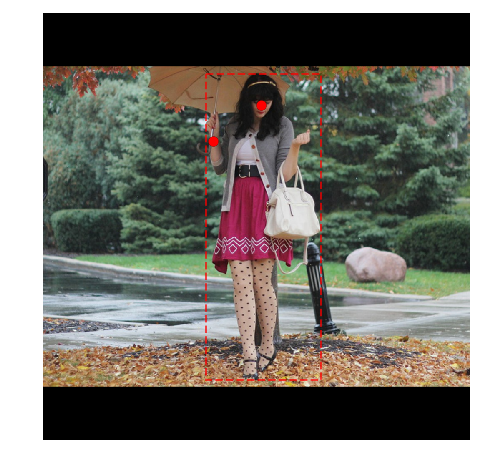

In [10]:
importlib.reload(visualize)

# Load a test image
image_id = dataset_val.image_ids[10]

# Get ground truth masks and bboxes
image, image_meta, gt_class_ids, gt_bbox, gt_kp_masks, gt_kp_ids = \
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id)

log("image", image)
log("gt_class_ids", gt_class_ids)
log("gt_kp_ids", gt_kp_ids)
log("gt_bbox", gt_bbox)
log("gt_masks", gt_kp_masks)

visualize.display_keypoints(image, gt_bbox, gt_kp_masks, gt_kp_ids,
                            #skeleton=dataset_train.skeleton,
                            figsize=(8, 8))

In [11]:
importlib.reload(modellib)
results = model.detect([image], verbose=1)
r = results[0]

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  146.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
mrcnn_mask.shape (1, 100, 2, 28, 28)
mrcnn_mask.dtype float32
detections.shape (100, 6)
mrcnn_mask.shape (100, 2, 28, 28)
masks.shape (100, 2, 28, 28)


image                    shape: (1024, 1024, 3)       min:    0.00000  max:  252.00000  uint8
class_ids                shape: (100,)                min:    1.00000  max:    1.00000  int32
kp_ids                   shape: (12, 17)              min:    0.00000  max:   16.00000  int64
bbox                     shape: (100, 4)              min:    3.00000  max: 1019.00000  int32
masks                    shape: (100, 2, 1024, 1024)  min:    0.00000  max:    0.00368  float64


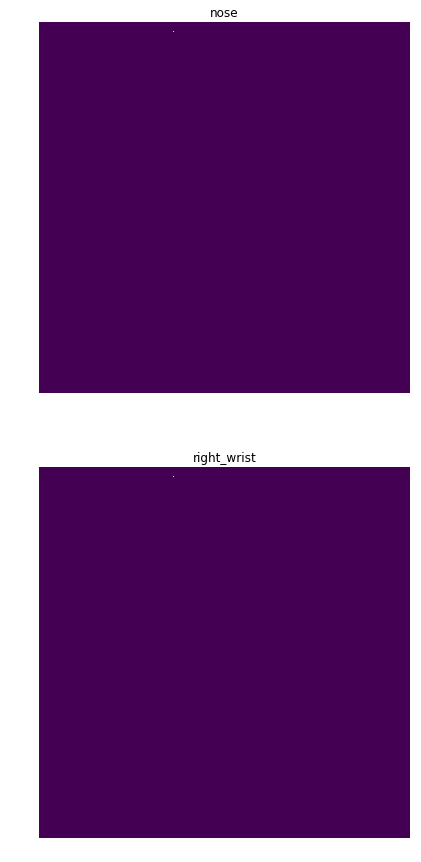

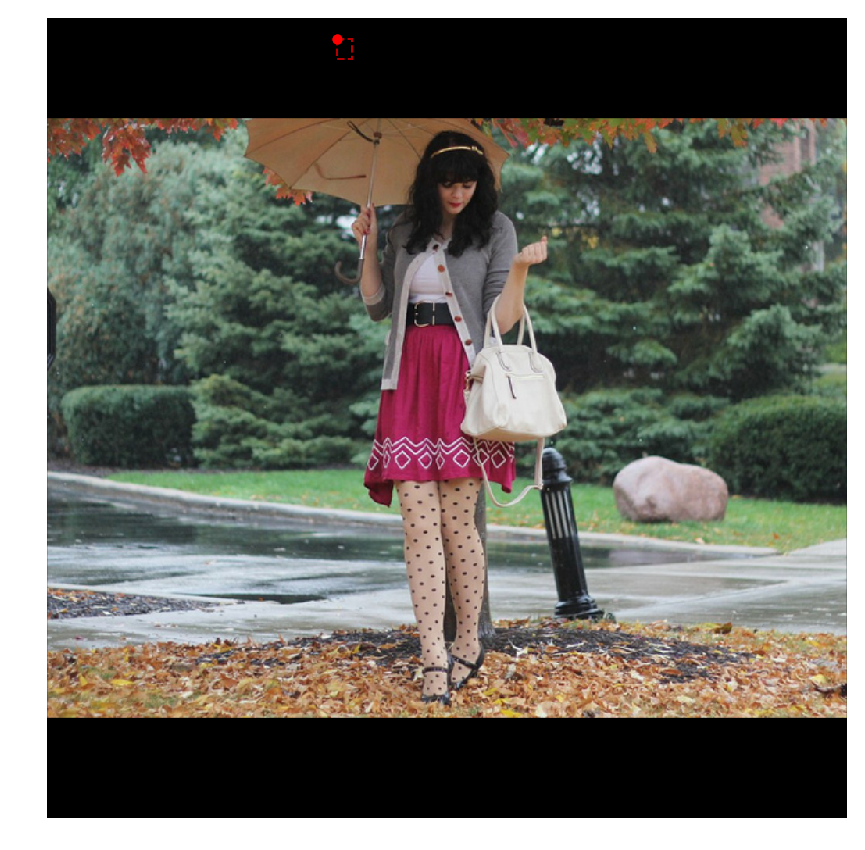

In [12]:
bbox, kp_masks, kp_ids = r["rois"], r["masks"], np.repeat(np.expand_dims(np.arange(17), axis=0), 12, axis=0)

log("image", image)
log("class_ids", r['class_ids'])
log("kp_ids", kp_ids)
log("bbox", bbox)
log("masks", kp_masks)

%matplotlib inline
import matplotlib.pyplot as plt

n = np.sqrt(inference_config.NUM_KEYPOINTS)
_, axes = plt.subplots(int(np.ceil(n)), int(np.floor(n)), figsize=(15, 15))
if n <= 1: axes = np.array(axes)
for i, ax in enumerate(axes.flatten()):
    ax.axis("off")
    if i >= inference_config.NUM_KEYPOINTS: continue
    #x, y = i % 4, i // 4
    
    ax.set_title(dataset_train.kp_class_names[i+1])
    ax.imshow(kp_masks[0, i])


plt.show()

visualize.display_keypoints(image, bbox[0:1], kp_masks[0:1],
                            #skeleton=dataset_train.skeleton
                            figsize=(15, 15))

In [13]:
print(r['class_ids'])
print(r["scores"])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0.9235702 0.9235702 0.9235702 0.9235702 0.9235702 0.9235702 0.9235702
 0.9235702 0.9235702 0.9235702 0.9235702 0.9235702 0.9235702 0.9235702
 0.9235702 0.9235702 0.9235702 0.9235702 0.9235702 0.9235702 0.9235702
 0.9235702 0.9235702 0.9235702 0.9235702 0.9235702 0.9235702 0.9235702
 0.9235702 0.9235702 0.9235702 0.9235702 0.9235702 0.9235702 0.9235702
 0.9235702 0.9235702 0.9235702 0.9235702 0.9235702 0.9235702 0.9235702
 0.9235702 0.9235702 0.9235702 0.9235702 0.9235702 0.9235702 0.9235702
 0.9235702 0.9235702 0.9235702 0.9235702 0.9235702 0.9235702 0.9235702
 0.9235702 0.9235702 0.9235702 0.9235702 0.9235702 0.9235702 0.9235702
 0.9235702 0.9235702 0.9235702 0.9235702 0.9235702 0.9235702 0.9235702
 0.9235702 0.9235702 0.9235702 0.9235702 0.9235702 0.9235702 0.9235702
 0.9235702 0.92

In [14]:
#visualize.display_keypoints(original_image, r['rois'], r['masks'], r['class_ids'],
#                            dataset_val.class_names, skeleton=None)

In [15]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
#print(det_class_ids)
#det_count = np.where(det_class_ids == 0)[0][0]
#det_class_ids = det_class_ids[:det_count]

#print("{} detections: {}".format(
#    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.00315  max:    1.00000  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00000  max:    0.00501  float32


In [16]:
# Masks
"""det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)"""

'det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])\ndet_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] \n                              for i, c in enumerate(det_class_ids)])\ndet_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)\n                      for i, m in enumerate(det_mask_specific)])\nlog("det_mask_specific", det_mask_specific)\nlog("det_masks", det_masks)'

In [17]:
#visualize.display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")